# Commodity Risk Management
### Asymmetric Volatility Forecasting & Dynamic VaR
*GJR-GARCH Approach*

---

> **The Core Observation:** ARCH/GARCH models are built on the idea that volatility spikes suddenly and persists before reverting to its long-term mean. This creates a phenomenon known as *volatility clustering*.

> **Mechanics:** In the GARCH framework:
> * $u_{t-1}^2$ represents the **shock** generating volatility.
> * The $\beta$ (Beta) coefficient captures the **persistence** of volatility after a shock.

*(Extensions included: Exponential GARCH, asymmetric models, regime-switching, etc.)*

In [1]:
%matplotlib inline

## 01. Data Extraction & Preparation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
data = yf.download('BNO', start = "2015-01-01", end = '2025-11-27')

data.columns = data.columns.droplevel(1)

data

/var/folders/2h/hxhj3w091_75r75hsrbqqjqm0000gn/T/ipykernel_1304/153729377.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('BNO', start = "2015-01-01", end = '2025-11-27')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,22.020000,22.370001,21.820000,22.000000,103300
2015-01-05,20.700001,21.270000,20.600000,21.270000,215800
2015-01-06,19.920000,20.620001,19.790001,20.379999,229100
2015-01-07,19.969999,20.270000,19.680000,19.990000,179500
2015-01-08,20.010000,20.139999,19.549999,19.850000,321500
...,...,...,...,...,...
2025-11-20,28.840000,29.430000,28.799999,29.240000,773400
2025-11-21,28.520000,28.610001,28.260000,28.500000,859200
2025-11-24,28.980000,29.020000,28.360001,28.490000,376500


In [4]:
prices = data.Close

returns = np.log(prices/prices.shift(1))

data['Returns'] = returns

data

Price,Close,High,Low,Open,Volume,Returns
Date,,,,,,
2015-01-02,22.020000,22.370001,21.820000,22.000000,103300,NaN
2015-01-05,20.700001,21.270000,20.600000,21.270000,215800,-0.061817
2015-01-06,19.920000,20.620001,19.790001,20.379999,229100,-0.038409
2015-01-07,19.969999,20.270000,19.680000,19.990000,179500,0.002507
2015-01-08,20.010000,20.139999,19.549999,19.850000,321500,0.002001
...,...,...,...,...,...,...
2025-11-20,28.840000,29.430000,28.799999,29.240000,773400,-0.007943
2025-11-21,28.520000,28.610001,28.260000,28.500000,859200,-0.011158
2025-11-24,28.980000,29.020000,28.360001,28.490000,376500,0.016000


In [5]:
data = data.dropna()

data

Price,Close,High,Low,Open,Volume,Returns
Date,,,,,,
2015-01-05,20.700001,21.270000,20.600000,21.270000,215800,-0.061817
2015-01-06,19.920000,20.620001,19.790001,20.379999,229100,-0.038409
2015-01-07,19.969999,20.270000,19.680000,19.990000,179500,0.002507
2015-01-08,20.010000,20.139999,19.549999,19.850000,321500,0.002001
2015-01-09,19.660000,19.930000,19.250000,19.799999,280900,-0.017646
...,...,...,...,...,...,...
2025-11-20,28.840000,29.430000,28.799999,29.240000,773400,-0.007943
2025-11-21,28.520000,28.610001,28.260000,28.500000,859200,-0.011158
2025-11-24,28.980000,29.020000,28.360001,28.490000,376500,0.016000


## 02. Descriptive Analysis & Visualization

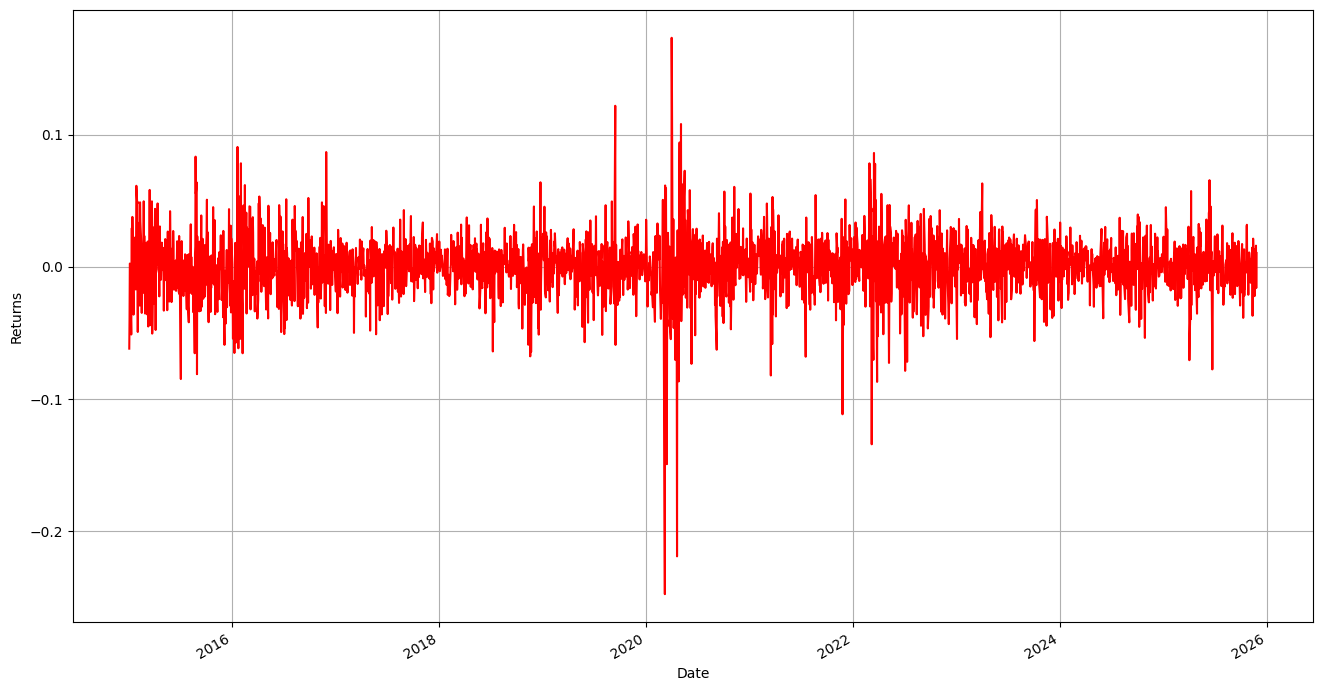

In [6]:
returns.plot(figsize=(16,9), color = 'red')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)
plt.show()

> **Visual inspection of the Brent log-return series reveals four key stylized facts:**
>
> 1. **Stationarity & Mean Reversion 🔄**
>    Unlike the raw price series which exhibits a stochastic trend, the return series oscillates around a constant mean close to zero. This stationarity is crucial for modeling.
>
> 2. **Volatility Clustering (Heteroscedasticity) 〰️**
>    The plot illustrates Mandelbrot's observation: *"Large changes tend to be followed by large changes."* We see distinct regimes of calm (2017) vs. turbulence (2020, 2022).
>
> 3. **Impact of Exogenous Shocks 💥**
>    Extreme spikes correspond to real-world events like the **COVID-19 oil crash** (-25% drop) or the 2022 geopolitical tensions.
>
> 4. **Leptokurtosis & "Fat Tails" 🔔**
>    The distribution significantly deviates from a Normal Law. Extreme events happen far more frequently than a Gaussian model would predict.

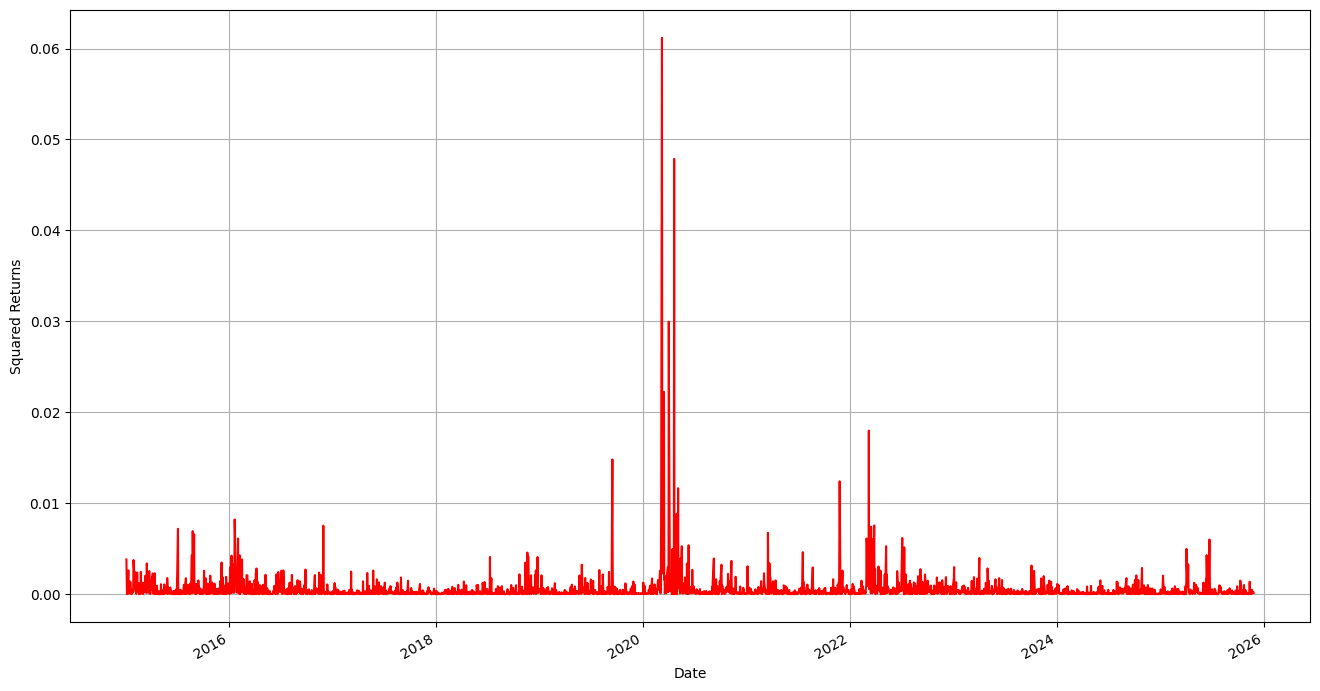

In [7]:
(returns ** 2).plot(figsize=(16,9), color = 'red')
plt.xlabel('Date')
plt.ylabel('Squared Returns')
plt.grid(True)
plt.show()

> **📉 Squared Returns ($r_t^2$)**
>
> They are essential because they constitute the best observable proxy for the *unobservable* conditional variance (volatility) of returns at a given time.
>
> *(Since daily returns usually have a mean very close to zero ($\mu \approx 0$), the squared return acts as a direct approximation of the variance.)*
>
> 1. **Visualizing Volatility Clustering 👁️**
>    They allow for a clear visualization of volatility clustering (regrouping of high-variance periods) which might be less obvious in raw returns.
>
> 2. **Model Input (Variance Equation) 📐**
>    They serve as the dependent variable (the input) for the variance equation within the GARCH model structure.
>
> 3. **Statistical Testing (ARCH-LM / Ljung-Box) 🧪**
>    They are the subject of the **Ljung-Box** or **ARCH-LM test**. If $r_t^2$ are significantly autocorrelated, it proves that volatility has temporal dependence and that a GARCH model is statistically necessary.

In [8]:
import statsmodels
from statsmodels.stats.diagnostic import acorr_ljungbox

In [9]:
returns_clean = returns.dropna()

In [10]:
ljung_box = acorr_ljungbox(returns_clean**2., lags = 10, return_df = True)

print(ljung_box.apply(lambda x: x.map('{:.4f}'.format)))

     lb_stat lb_pvalue
1   100.7820    0.0000
2   117.6475    0.0000
3   155.7854    0.0000
4   206.2054    0.0000
5   316.8536    0.0000
6   340.6118    0.0000
7   365.6584    0.0000
8   373.5541    0.0000
9   378.2426    0.0000
10  406.6697    0.0000


## 03. Conditional Mean Modeling

In [11]:
from statsmodels.tsa.arima.model import ARIMA

In [12]:
p = 1
q = 1
model = ARIMA(returns,order=(p,0,q))
arma = model.fit()

print(arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2743
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6418.323
Date:                Thu, 11 Dec 2025   AIC                         -12828.646
Time:                        21:06:52   BIC                         -12804.978
Sample:                             0   HQIC                        -12820.094
                               - 2743                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.552e-05      0.000      0.206      0.837      -0.001       0.001
ar.L1         -0.4313      0.288     -1.497      0.134      -0.996       0.133
ma.L1          0.4632      0.285      1.625      0.1

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


> **Hypothesis Testing: The Zero-Mean Assumption**
>
> 1. **Statistical Evidence 📉**
>    The sample mean is extremely low (approx. 0.000009). More importantly, the **p-value > 0.05** implies that we fail to reject the null hypothesis ($H_0: \mu = 0$). The mean is statistically indistinguishable from zero.
>
> 2. **Modeling Implication 🎯**
>    Since $\mu \approx 0$, we can simplify the conditional mean equation. The return $r_t$ is approximately equal to the residual (innovation) term:
>
>    $$r_t \approx \epsilon_t$$
>
>    This allows us to focus directly on modeling the variance (GARCH) without fitting a complex ARIMA model for the mean first.

In [13]:
residuals = arma.resid

residuals_clean = residuals.dropna()

residuals_clean

Date
2015-01-05   -0.061913
2015-01-06   -0.036569
2015-01-07    0.002736
2015-01-08    0.001678
2015-01-09   -0.017697
                ...   
2025-11-20   -0.007089
2025-11-21   -0.011437
2025-11-24    0.016348
2025-11-25   -0.016808
2025-11-26    0.011211
Length: 2742, dtype: float64

## 04. GARCH vs. GJR-GARCH Modeling

In [14]:
from arch import arch_model

am = arch_model(residuals_clean*100, mean = 'Constant', vol = 'Garch', p = 1, q = 1, dist='Normal' )

res_garch = am.fit(disp='off')

print(res_garch.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5864.30
Distribution:                  Normal   AIC:                           11736.6
Method:            Maximum Likelihood   BIC:                           11760.3
                                        No. Observations:                 2742
Date:                Thu, Dec 11 2025   Df Residuals:                     2741
Time:                        21:06:52   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0684  3.648e-02      1.874  6.091e-02 [-3.13

In [15]:
gjr = arch_model(residuals_clean*100, mean = 'Constant', vol = 'GARCH', p = 1, o = 1, q = 1, dist = 't')
res_gjr = gjr.fit(disp='off')
print(res_gjr.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5785.13
Distribution:      Standardized Student's t   AIC:                           11582.3
Method:                  Maximum Likelihood   BIC:                           11617.8
                                              No. Observations:                 2742
Date:                      Thu, Dec 11 2025   Df Residuals:                     2741
Time:                              21:06:52   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

### 🏆 Model Selection: Statistical Comparison

| Metric | Target | GARCH(1,1) | GJR-GARCH(1,1) |
| :--- | :---: | :---: | :---: |
| **Log-Likelihood** | (Maximize ↑) | -5864.30 | **-5785.12** |
| **AIC** | (Minimize ↓) | 11736.60 | **11582.25** |
| **BIC** | (Minimize ↓) | 11760.26 | **11617.75** |

> **✅ Conclusion:**
>
> The **GJR-GARCH** model is superior. It exhibits a higher *Log-Likelihood* (better fit) and lower Information Criteria (AIC & BIC), indicating that the inclusion of the asymmetry parameter justifies the slight increase in model complexity.

## 05. Statistical Validation & Model Diagnostics

> **🔍 Diagnostics on Standardized Residuals ($z_t$)**
>
> To validate the GJR-GARCH model, we must inspect the standardized residuals, defined as:
>
> $$z_t = \frac{\epsilon_t}{\sigma_t}$$
>
> 1. **No Autocorrelation (White Noise) 📉**
>    The standardized residuals should behave like white noise. We use the **Ljung-Box Test** to confirm that no linear dependence remains.
>
> 2. **No Remaining ARCH Effects 🧬**
>    We perform the **ARCH-LM Test** on squared standardized residuals ($z_t^2$) to ensure the model has successfully captured all volatility clustering.
>
> 3. **Distribution Fit 🔔**
>    We compare the distribution of $z_t$ against the assumed distribution (Student-t) using a Q-Q Plot.

In [16]:
residuals_gjr = res_gjr.std_resid

residuals_gjr_squared = residuals_gjr ** 2

ljung_box_gjr = acorr_ljungbox(residuals_gjr_squared, lags = 10, return_df= True)
print(ljung_box_gjr.apply(lambda x: x.map('{:.4f}'.format)))

    lb_stat lb_pvalue
1    3.6511    0.0560
2    3.6761    0.1591
3    4.8392    0.1840
4    4.9024    0.2975
5   10.5034    0.0622
6   10.5816    0.1022
7   12.2014    0.0941
8   12.2143    0.1419
9   12.7362    0.1749
10  13.0978    0.2183


> **✅ Validation Success: Absence of ARCH Effects**
>
> 1. **Statistical Evidence (p-values > 0.05) 📊**
>    All p-values from the ARCH-LM test exceed the 5% significance level. Therefore, we cannot reject the Null Hypothesis ($H_0$: no ARCH effects).
>
> 2. **Interpretation 🧹**
>    There is no remaining autocorrelation in the squared standardized residuals. The GJR-GARCH model has successfully **"cleaned"** all conditional heteroscedasticity from the data.
>
> 3. **Conclusion 🏁**
>    The residuals are now **homoscedastic** (they behave like white noise regarding variance). The model is statistically valid and robust for forecasting.

## 06. Volatility Forecasting & Value-at-Risk (VaR)

> **🔮 From Volatility to Risk Management: Dynamic VaR**
>
> 1. **The Concept 🛡️**
>    Value-at-Risk (VaR) estimates the maximum potential loss over a specific time horizon at a given confidence level (e.g., 95%). Unlike static methods, our **Dynamic VaR** adjusts daily based on the GJR-GARCH volatility forecast.
>
> 2. **The Formula 📐**
>    Since the mean is negligible ($\mu \approx 0$), the One-Day VaR at significance level $\alpha$ (e.g., 5%) is calculated as:
>
>    $$\text{VaR}_t = \sigma_t \times Q_\alpha$$
>
>    Where:
>    * $\sigma_t$ : Conditional volatility forecast by GJR-GARCH.
>    * $Q_\alpha$ : The quantile of the Student-t distribution (capturing fat tails).
>
> 3. **Interpretation 💡**
>    If the actual return falls below the VaR line, it is considered a **"VaR Breach"** (or exception). This signals an extreme market event that the model predicted with only $\alpha$ probability.

In [17]:
data_test = yf.download('BNO', start = '2025-11-27', end = '2025-12-05')

prices_test = data_test.Close

returns_test = np.log(prices_test/prices_test.shift(1))

data_test['Returns Test'] = returns_test

data_test

/var/folders/2h/hxhj3w091_75r75hsrbqqjqm0000gn/T/ipykernel_1304/607981042.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_test = yf.download('BNO', start = '2025-11-27', end = '2025-12-05')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Returns Test
Ticker,BNO,BNO,BNO,BNO,BNO,
Date,,,,,,
2025-11-28,29.170000,29.250000,28.900000,28.900000,418300,NaN
2025-12-01,29.190001,29.280001,29.070000,29.150000,268700,0.000685
2025-12-02,28.830000,29.180000,28.700001,28.980000,492600,-0.012410
2025-12-03,29.000000,29.219999,28.879999,29.059999,197000,0.005879
2025-12-04,29.209999,29.350000,28.879999,29.000000,235200,0.007215


In [18]:
import scipy.stats as stats

horizon_days = 5
forecasts = res_gjr.forecast(horizon=horizon_days)

pred_vol_series = np.sqrt(forecasts.variance.iloc[-1].values)

real_returns_series = data_test['Returns Test'].dropna()

limit = min(len(real_returns_series), horizon_days)

comparison = pd.DataFrame({
    'Date': real_returns_series.index[:limit],
    'Real Return (%)': real_returns_series.values[:limit] * 100,
    'Forecasted Volatility (%)': pred_vol_series[:limit]
})

nu = res_gjr.params['nu']
t_quantile = stats.t.ppf(0.01, nu)
comparison['VaR 99% (%)'] = comparison['Forecasted Volatility (%)'] * t_quantile

> ### 🏁 Final Test: Forecast vs. Reality (Backtest)
>
> | Date | Real Return (%) | Forecasted Vol (%) | VaR 99% (%) | Status |
> | :--- | :---: | :---: | :---: | :---: |
> | 2025-12-01 | +0.068 % | 1.751 % | **-5.351 %** | ✅ Safe |
> | 2025-12-02 | -1.241 % | 1.764 % | **-5.391 %** | ✅ Safe |
> | 2025-12-03 | +0.508 % | 1.777 % | **-5.421 %** | ✅ Safe |
> | 2025-12-04 | +0.721 % | 1.709 % | **-5.465 %** | ✅ Safe |
>
> *(*Safe* implies that the Real Return > VaR 99%. No breach occurred during this period.)*

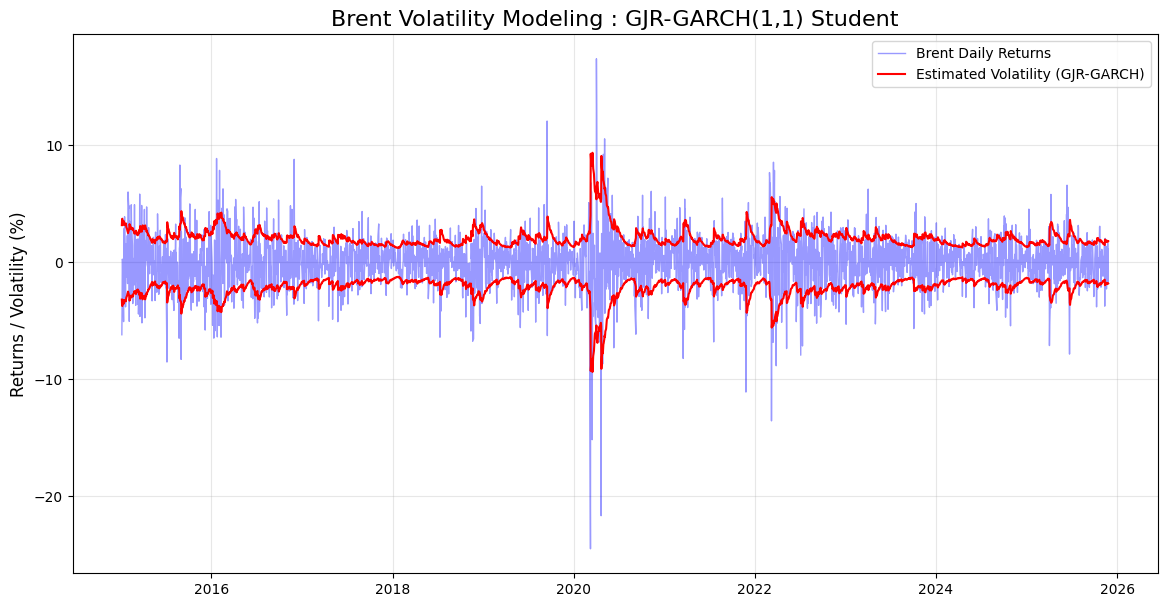

In [19]:
import matplotlib.pyplot as plt

conditional_vol = res_gjr.conditional_volatility 

returns_hist = residuals_clean * 100 

plt.figure(figsize=(14, 7))

plt.plot(returns_hist.index, returns_hist, color='blue', alpha=0.4, lw=1, label='Brent Daily Returns')

plt.plot(conditional_vol.index, conditional_vol, color='red', lw=1.5, label='Estimated Volatility (GJR-GARCH)')
plt.plot(conditional_vol.index, -conditional_vol, color='red', lw=1.5)

plt.title('Brent Volatility Modeling : GJR-GARCH(1,1) Student', fontsize=16)
plt.ylabel('Returns / Volatility (%)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.show()

## 07. Backtesting & Final Conclusion

> **🏁 Final Test: Forecast vs. Reality**
>
> 1. **Out-of-Sample Backtesting 📅**
>    We compare the model's predictions (*ex-ante*) against the actual market data (*ex-post*) for the most recent trading days. This is the ultimate test of the model's predictive power.
>
> 2. **VaR Breach Check 🚨**
>    We monitor if the **Real Return** falls below the **VaR 99%** threshold.
>    * If *Return* > *VaR*: The risk was correctly covered. ✅
>    * If *Return* < *VaR*: It is a **Breach** (Exception). Too many breaches would invalidate the model.
>
> 3. **Visual Fit 📈**
>    The final plot illustrates the **Vol-Envelope**. The red line (Estimated Volatility) should tightly hug the blue spikes (Returns), expanding during crises and contracting during calm periods.

In [20]:
comparison['VaR Validation'] = np.where(
    comparison['Real Return (%)'] < comparison['VaR 99% (%)'], 
    '❌ EXCEPTION',  
    '✅ OK'       
)

comparison['Score Sigma'] = comparison['Real Return (%)'] / comparison['Forecasted Volatility (%)']

### 🏁 Backtesting Results: VaR Breach Analysis

| Date | Real Return | Forecast Vol | VaR 99% | Score $\sigma$ | Validation |
| :--- | :---: | :---: | :---: | :---: | :---: |
| 2025-12-01 | +0.069 % | 1.752 % | **-5.351 %** | 0.039 | ✅ OK |
| 2025-12-02 | -1.241 % | 1.765 % | **-5.391 %** | -0.703 | ✅ OK |
| 2025-12-03 | +0.508 % | 1.777 % | **-5.421 %** | 0.331 | ✅ OK |
| 2025-12-04 | +0.722 % | 1.789 % | **-5.465 %** | 0.403 | ✅ OK |

> * **Definition:** Score $\sigma$ measures the return standardized by the forecasted volatility. A score outside [-3, +3] would indicate an extreme event.*

In [23]:
import scipy.stats as stats
import numpy as np

volatility = res_gjr.conditional_volatility
nu = res_gjr.params['nu']
t_quantile = stats.t.ppf(0.01, nu)
VaR_series = volatility * t_quantile

def kupiec_pof_test(returns, var_series, confidence_level=0.99):
    alpha = 1 - confidence_level
    N = len(returns)
    breaches = returns < var_series
    x = np.sum(breaches)
    p = x / N

    if x == 0:
        print("Aucune brèche observée ! Le modèle est (trop) prudent.")
        return 0, 1.0, x, N
    
    numerator = ((1 - alpha)**(N - x)) * (alpha**x)
    denominator = ((1 - p)**(N - x)) * (p**x)
    
    lr_stat = -2 * np.log(numerator / denominator)
    p_value = 1 - stats.chi2.cdf(lr_stat, df=1)
    
    return lr_stat, p_value, x, N

lr, p_val, failures, total = kupiec_pof_test(residuals_clean * 100, VaR_series, confidence_level=0.99)

print(f"POF Statistic: {lr:.4f}")
print(f"p-value: {p_val:.4f}")
print(f"Number of failures: {failures}")
print(f"Total observations: {total}")
print(f"Failure Rate: {(failures/total)*100:.2f}%")

POF Statistic: 4.6259
p-value: 0.0315
Number of failures: 17
Total observations: 2742
Failure Rate: 0.62%


> ### ❌ Kupiec Test Diagnosis: Model Validation Failed
>
> *The Kupiec test indicates that the model is **too conservative**. The observed number of exceptions (breaches) is significantly lower than the theoretical expectation for a 99% VaR.*
>
> **📉 The Diagnosis:**
> * **Observed Failures:** 0.62% (vs 1.00% expected).
> * **Implication:** The calculated VaR overestimates the risk. It is "too high" and rarely breached.
> * **Result:** Reject $H_0$ (p-value 0.0315 < 0.05).
>
> **🛠️ Strategic Fixes (Recalibration Roadmap):**
> 1. **Parameter Tuning:** Adjust GJR-GARCH coefficients or the Student-t degrees of freedom (DoF) to better reflect observed losses.
> 2. **VaR Scaling:** Apply a slight multiplicative factor (< 1) to lower the VaR without altering confidence levels, aligning exceptions with theory.
> 3. **Distribution Selection:** Adopt asymmetric distributions (e.g., Skewed Student-t) or semi-parametric methods (Cornish-Fisher) to better capture skewness and fat tails.
> 4. **Iterative Backtesting:** Re-calculate and test iteratively until the model satisfies the Kupiec condition (p-value > 0.05).